<img src="https://geodecode.com.br/wp-content/uploads/2021/12/brasildatacube.png" align="left" width="74"/>
<img src="https://brazil-data-cube.github.io/_images/logo-odc-bdc.png" align="right" width="74" />

<h1 style="color:#336699; text-align: center" >Annual Metting Use Case</h1>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    <sup>
        <a href="https://orcid.org/0000-0002-9916-1167">
            <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i>
        </a>
    </sup>
    <br/>
    Brazil Data Cube (BDC), National Institute for Space Research (INPE)
    <br/>
    <br/>
    <br/>
    <div style="width: 98%;">
        <div style="text-align: justify; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 10px;">
            <b>Explantion here....:</b>
            <div>
                Write write write write writewrite writewrite write. <a href="http://www.brazildatacube.org/" target="_blank">Site site site site site</a>, <i> Outras infos</i> .......
            </div>
        </div>
    </div>
</div>

In [8]:
# # library(geojsonsf)
# # library(sfheaders)
# library(jsonlite)
# library(httr)
library(sf)
# library(raster)
# library(rstac)
# library(gdalcubes)
# library(tmap)
# library(dplyr)
# library(ggplot2)
library(sits)

SITS - satellite image time series analysis.

Loaded sits v1.4.2-1.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.



# Set constants and ROI
<hr style="border:1px solid #0077b9;">

### If BDC-Lab, set config.yaml

In [ ]:
# Set config if using BDC Lab
sits_config(config_user_file = "config.yaml")

### Set constants

In [2]:
MULTICORES <- 3L
# MULTICORES <- 60L

FINAL_CSV_PREFIX <- "data_36_months_"

START_DATE <- "2019-01-01"
END_DATE <- "2019-03-30"

### Get ROI and BBOX

In [6]:
shape_sf <- st_read("roi/mun_indireto_PA.shp")
shape_df <- data.frame(shape_sf)

dim(shape_df)
head(shape_df)

bbox <- st_bbox(shape_sf)
bbox

Reading layer `mun_indireto_PA' from data source 
  `/home/luana/git/harmonize/annual_meeting_use_case/roi/mun_indireto_PA.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 21 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -50.9967 ymin: -5.196937 xmax: -48.13749 ymax: -1.019427
Geodetic CRS:  SIRGAS 2000


[1] 21  6

,CD_MUN,NM_MUN,SIGLA,AREA_KM2,cod,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<POLYGON [°]>
1,1500107,Abaetetuba,PA,1610.654,NA,POLYGON ((-48.83139 -1.5635...
2,1500800,Ananindeua,PA,190.581,NA,POLYGON ((-48.33466 -1.2398...
3,1501105,Bagre,PA,4397.321,NA,POLYGON ((-50.29255 -1.8063...
4,1501204,Baião,PA,3759.834,NA,POLYGON ((-49.48643 -2.6631...
5,1501303,Barcarena,PA,1310.338,NA,POLYGON ((-48.4695 -1.59545...
6,1501402,Belém,PA,1059.466,NA,POLYGON ((-48.35304 -1.2210...


      xmin       ymin       xmax       ymax 
-50.996702  -5.196937 -48.137491  -1.019427 

# List SITS collections
<hr style="border:1px solid #0077b9;">

In [9]:
sits_list_collections()

BDC:
- CBERS-WFI-16D (CBERS-4/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-WFI-8D (CBERS-4-4A/WFI)
- grid system: BDC-Large V2
- bands: NDVI EVI B13 B14 B15 B16 CLOUD
- opendata collection (requires access token)

- CBERS-MUX-2M (CBERS-4/MUX)
- grid system: BDC-Medium V2
- bands: NDVI EVI B05 B06 B07 B08 CLOUD
- opendata collection (requires access token)

- LANDSAT-OLI-16D (LANDSAT-8/OLI)
- grid system: BDC-Medium V1
- bands: NDVI EVI COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 CLOUD
- opendata collection (requires access token)

- LANDSAT-2M (LANDSAT/TM-ETM-OLI)
- grid system: BDC-Medium V2
- bands: COASTAL BLUE GREEN RED NIR08 SWIR16 SWIR22 NDVI EVI CLOUD
- opendata collection (requires access token)

- MOD13Q1-6 (TERRA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED NIR MIR CLOUD
- opendata collection (requires access token)

- MYD13Q1-6 (AQUA/MODIS)
- grid system: STG
- bands: NDVI EVI BLUE RED 

# 1. Compute NDVI mean for each municipality
<hr style="border:1px solid #0077b9;">

<!-- ![Figure 2](https://raw.githubusercontent.com/e-sensing/sitsbook/master/images/data_cube_generation.png) -->


### 1.1 Create output folders

In [14]:
# FOlders names
ORIGINAL_IMAGES_FOLDER <- "original_tifs"
MONTHLY_IMAGES_FOLDER <- "montly_aggr_by_tile"
MOSAIC_IMAGES_FOLDER <- "mosaic_by_month"
MOSAIC_CSVS_IMAGES_FOLDER <- "mosaic_by_month_csvs"

# Create folders if not created
folders_to_create <- c(ORIGINAL_IMAGES_FOLDER, MONTHLY_IMAGES_FOLDER, MOSAIC_IMAGES_FOLDER, MOSAIC_CSVS_IMAGES_FOLDER)
for (folder_name in folders_to_create){
  if (!file.exists(folder_name)) {
    dir.create(folder_name, recursive = TRUE)
    print(paste0(folder_name, " folder created successfully."))
  }
}

### 1.2 Set collection id

In [11]:
COLLECTION_ID <- "SENTINEL-2-16D"

### 1.3 Search images using sits_cube (get metadata)

Warning message:
“object has no crs, assuming 'EPSG:4326'”


  |======================================================================| 100%
[1] "Execution time: 31.9989240169525"


[1] "2019-01-01" "2019-01-17" "2019-02-02" "2019-02-18" "2019-03-06"
[6] "2019-03-22"

# A tibble: 12 × 14
   fid      date       band   xres  yres   xmin   ymin   xmax   ymax nrows ncols
   <chr>    <date>     <chr> <dbl> <dbl>  <dbl>  <dbl>  <dbl>  <dbl> <dbl> <dbl>
 1 S2-16D_… 2019-01-01 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 2 S2-16D_… 2019-01-01 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 3 S2-16D_… 2019-01-17 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 4 S2-16D_… 2019-01-17 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 5 S2-16D_… 2019-02-02 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 6 S2-16D_… 2019-02-02 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 7 S2-16D_… 2019-02-18 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 8 S2-16D_… 2019-02-18 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
 9 S2-16D_… 2019-03-06 CLOUD    10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
10 S2-16D_… 2019-03-06 NDVI     10    10 5.26e6 1.12e7 5.37e6 1.13e7 10560 10560
11 S2-16

plotting false color image



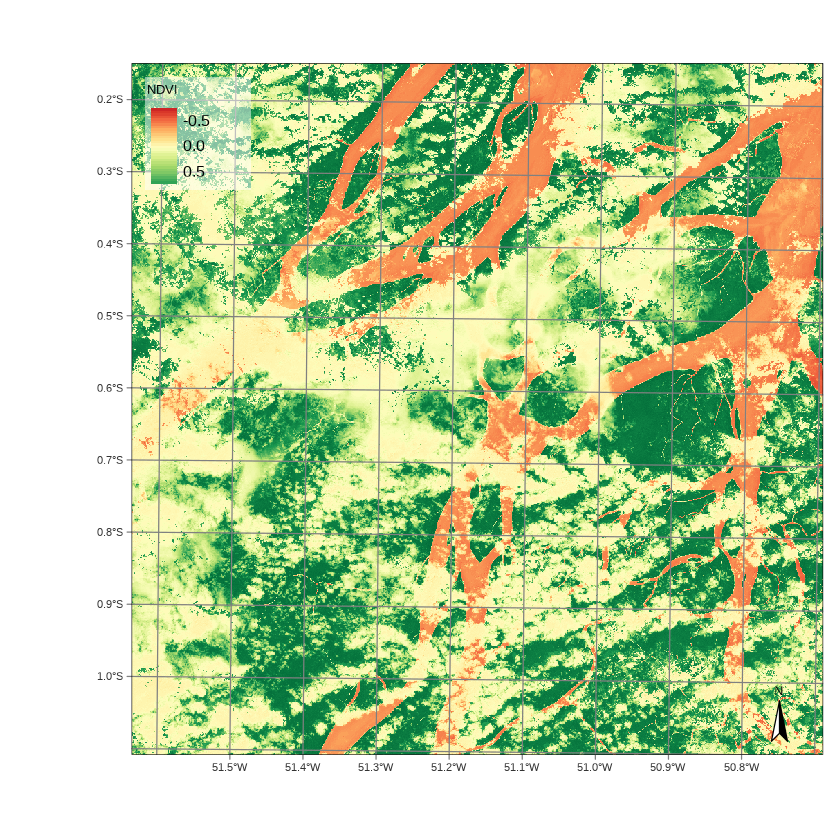

In [12]:
# Obtain metadata
st <- Sys.time()
s2_cube <- sits_cube(
  source = "BDC",
  collection = COLLECTION_ID,
  bands = c("NDVI", "CLOUD"),
  roi = bbox,
  start_date = START_DATE,
  end_date = END_DATE,
  progress = TRUE
)
print(paste0("Execution time: ", Sys.time() - st))

sits_timeline(s2_cube)
print(s2_cube$file_info[[1]])
plot(s2_cube, band = "NDVI", time = 1)

### 1.4 Download all images loccaly
- For 3 years, bands "NDVI","CLOUD", approximately 380 GB
- Using 60 cores, it took 50s to download 34GB (288 files).

In [17]:
st <- Sys.time()
cube_local <- sits_cube_copy(
  cube = s2_cube,
  output_dir = ORIGINAL_IMAGES_FOLDER,
  multicores = MULTICORES
)
print(paste0("Execution time: ", Sys.time() - st))

head(t(cube_local))

  |======================================================================| 100%
[1] "Execution time: 28.6119117736816"


source,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC,⋯,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC,BDC
collection,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,⋯,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D,SENTINEL-2-16D
satellite,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,⋯,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2,SENTINEL-2
sensor,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI,⋯,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI,MSI
tile,025006,025007,025008,025009,025010,025011,026006,026007,026008,026009,⋯,027008,027009,027010,027011,028006,028007,028008,028009,028010,028011
xmin,5264000,5264000,5264000,5264000,5264000,5264000,5369600,5369600,5369600,5369600,⋯,5475200,5475200,5475200,5475200,5580800,5580800,5580800,5580800,5580800,5580800


### 1.5 Aggregate all tiles of same month in one
- Using 60 cores, it took 2.4 min to aggregate 288 images in 72 (tile/month)

  |======================================================================| 100%
[1] "Execution time: 21.1910085678101"


[1] "2019-01-01" "2019-02-01" "2019-03-01"

plotting false color image

stars object downsampled to 831 by 1201 cells. See tm_shape manual (argument raster.downsample)



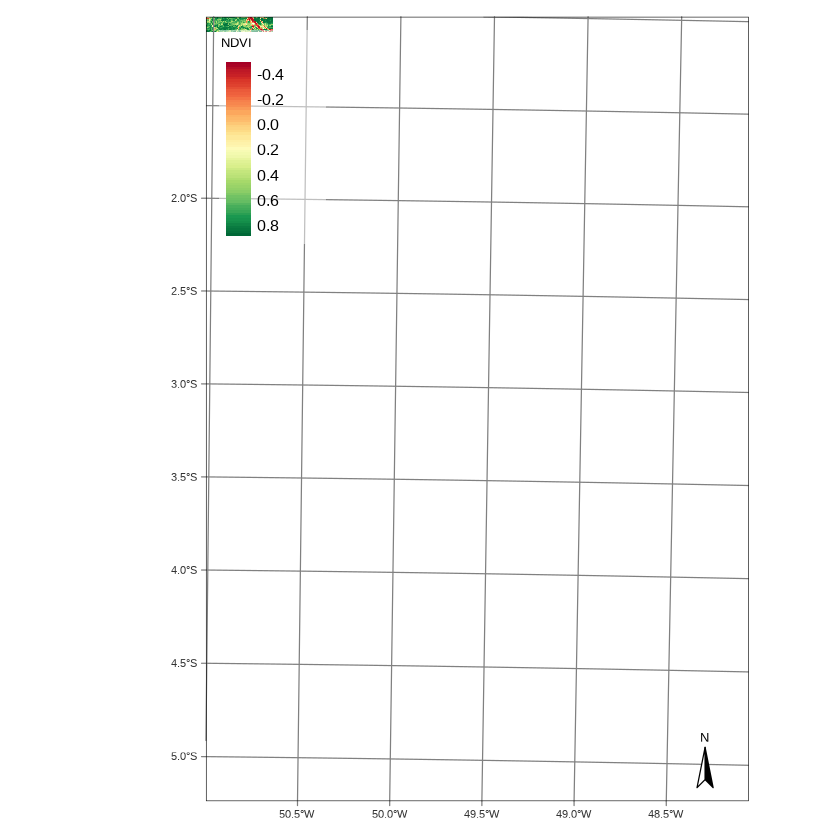

In [18]:
st <- Sys.time()
s2_regular_cube <- sits_regularize(
  cube_local,
  res = 10,
  # res = 60,
  output_dir = MONTHLY_IMAGES_FOLDER,
  period = "P1M",
  multicores = MULTICORES
)
print(paste0("Execution time: ", Sys.time() - st))

sits_timeline(s2_regular_cube)
plot(s2_regular_cube, band = "NDVI", time = 1)

### 1.6 Mosaic all montly aggregated tiles by month
- It took approximately 10 min to mosaic 72 images in 3 (mosaic/month)

In [ ]:
st <- Sys.time()

mosaic_cube <- sits_mosaic(
  cube = s2_regular_cube,
  roi = bbox,
  crs = "EPSG:4326",
  output_dir = "mosaic2", #MOSAIC_IMAGES_FOLDER,
  progress = TRUE,
  multicores = MULTICORES
)
print(paste0("Execution time: ", Sys.time() - st))

plot(mosaic_cube, band = "NDVI", time = 1)


### 1.7 For each computed mosaic, extract mean for each municipality

In [13]:
mosaic_filepaths <- list.files("mosaic_by_month", full.names = TRUE)
mosaic_filepaths

character(0)

In [8]:
extract_ndvi_to_csv <- function(tif_filepath, shape_sf) {
  # Open raster
  r <- raster::raster(tif_filepath)

  # Extract value based on shapefile
  extracted_values <- raster::extract(r, shape_sf, fun = mean, df = TRUE, na.rm = TRUE)

  # TODO: Some rasters will not intersect with shape if raster is not the mosaic

  # Merge extracted df (ID and NDVI columns) with original shapefile
  extracted_values <- data.frame(shape_sf, extracted_values)

  # Write csv of extracted data
  tif_id <- gsub("\\.tif$", "", basename(tif_filepath))
  csv_output_filepath <- file.path(MOSAIC_CSVS_IMAGES_FOLDER, paste0(tif_id, ".csv"))
  write.csv(extracted_values, csv_output_filepath)

  return(extracted_values)
}

st <- Sys.time()
df_extracted <- extract_ndvi_to_csv("tifs/SENTINEL-2_MSI_028007_NDVI_2019-01-01.tif", shape_sf)
print(paste0("Execution time: ", Sys.time() - st))

dim(df_extracted)
head(df_extracted)

class      : RasterStack 
dimensions : 10560, 10560, 111513600, 1  (nrow, ncol, ncell, nlayers)
resolution : 10, 10  (x, y)
extent     : 5369600, 5475200, 11003200, 11108800  (xmin, xmax, ymin, ymax)
crs        : +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs 
names      : SENTINEL.2_MSI_026008_NDVI_2019.06.26 


Warning message in .local(x, y, ...):
“Transforming SpatialPolygons to the crs of the Raster”
Warning message in .getRat(x, ratvalues, ratnames, rattypes):
“NAs introduced by coercion”


: 

### Open all monthly csvs and merge

In [15]:
mosaic_csvs_filepaths <- list.files(MOSAIC_CSVS_IMAGES_FOLDER, full.names = TRUE)
mosaic_csvs_filepaths

[1] "mosaic_by_month_csvs/SENTINEL-2_MSI_MOSAIC_2019-01-01_2019-01-01_NDVI_v1.csv"

In [16]:
# ndvi_df

# mean_NDVI <- a1 %>%
#   group_by(ID) %>%
#   summarize(
#     mean_ndvi = mean(NDVI, na.rm = TRUE)
#   )

# dim(mean_NDVI)
# head(mean_NDVI)

# mean_for_municipality <- merged %>%
#     group_by(CD_MUN) %>%
#     summarize(
#         ndvi_mean = mean(NDVI, na.rm=T),
#     ) %>%
#     filter(!is.na(ndvi_mean))

# dim(mean_for_municipality)
# head(mean_for_municipality)

### Save NDVI data

In [ ]:
FILENAME <- paste0(FINAL_CSV_PREFIX, "ndvi.csv")

write.csv(ndvi_df, FILENAME, row.names = FALSE)